# Lesson 3 project 1: Taxi path lengths

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import awkward as ak

<br><br><br>

## Chicago taxis

The City of Chicago has a [Data Portal](https://data.cityofchicago.org/) with lots of interesting datasets.

This exercise uses a dataset of [Chicago taxi trips](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew) taken from 2019 through 2021 (3 years).

Here's a map of Chicago, for reference:

<center>
<img src="../img/USA_Chicago_location_map.svg" width="500px">
</center>

Taxis rarely drive into the lake (blue on the right), but they do often go to the airport (yellow ball on the top-left).

The dataset that the Data Portal provides has trip start and stop points as longitude, latitude pairs, as well as start and end times (date-stamps), payment details, and the name of each taxi company.

For this exercise, I also added an estimated route of each taxi trip using [Open Source Routing Machine (OSRM)](http://project-osrm.org/).

The dataset has three levels of nesting:

   1. taxis
   2. trips taken by each taxi
   3. points along each trip taking by each taxi

and those levels have variable lengths: each taxi takes a different number of trips and each trip has a different number of points.

Our dataset is formatted as a 611 MB [Apache Parquet](https://parquet.apache.org/) file, provided here: [https://zenodo.org/records/14537442/files/chicago-taxi.parquet](https://zenodo.org/records/14537442/files/chicago-taxi.parquet).

<br><br><br>

## Reading the dataset

We can use Awkward Array's [ak.from_parquet](https://awkward-array.org/doc/main/reference/generated/ak.from_parquet.html) function to read the data.

In [2]:
taxi = ak.from_parquet(
    "https://zenodo.org/records/14537442/files/chicago-taxi.parquet",
    row_groups=[0],
)
taxi

<Array [[{trip: {...}, ...}, ..., {...}], ...] type='353 * var * {trip: {se...'>

<br><br><br>

### Specifying row groups

We use `row_groups=[0]` to read (that is, download) only a representative part of the dataset. Row groups are contiguous rows of data in the file; the smallest granularity that can be read.

This row group has 353 entries (taxis), which is about 4% of the dataset because the file has 25 row groups.

In [3]:
ak.metadata_from_parquet(
    "https://zenodo.org/records/14537442/files/chicago-taxi.parquet"
)["num_row_groups"]

25

<img src="../img/columns-and-row-groups.svg" width="100%">

Despite the terms "row" and "column", the data have a complex type:

In [4]:
taxi.type.show()

353 * var * {
    trip: {
        sec: ?float32,
        km: ?float32,
        begin: {
            lon: ?float64,
            lat: ?float64,
            time: ?datetime64[ms]
        },
        end: {
            lon: ?float64,
            lat: ?float64,
            time: ?datetime64[ms]
        },
        path: var * {
            londiff: float32,
            latdiff: float32
        }
    },
    payment: {
        fare: ?float32,
        tips: ?float32,
        total: ?float32,
        type: categorical[type=string]
    },
    company: categorical[type=string]
}


According to the above, this is an array of `353` elements, and each element is a variable length list (`var`) of records. Each list represents one taxi and each record in each list is a taxi trip.

The `trip` field contains a record with

   * `sec`: duration of taxi ride in seconds
   * `km`: distance traveled in kilometers
   * `begin.lon`, `begin.lat`: beginning longitude and latitude
   * `begin.time`: beginning time of trip
   * `end.*`: ending longitude, latitude, and time of trip
   * `path.londiff`, `path.latdiff`: reconstructed path relative to `begin.lon`, `begin.lat`

The `payment` field contains a record with

   * `fare`: nominal taxi fare in U.S. dollars
   * `tips`: optional tips
   * `total`: total paid (including any taxes or other fees)
   * `type`: method of payment

And the `company` field contains the name of the taxi company.

<br><br><br>

### Specifying columns

This exercise only uses a few of the columns:

   * `trip.km`
   * `trip.begin.l*` (begin longitude and latitude, but not time)
   * `trip.path.*` (full paths)

We can avoid reading (that is, downloading) the data we won't use by specifying `columns`.

In [5]:
taxi_columns = ak.from_parquet(
    "https://zenodo.org/records/14537442/files/chicago-taxi.parquet",
    columns=["trip.km", "trip.begin.l*", "trip.path.*"],
    row_groups=[0],
)
taxi_columns

<Array [[{trip: {...}}, ..., {...}], ...] type='353 * var * ?{trip: {km: ?f...'>


That produces a projection of the data type—records with only the fields we want.

In [6]:
taxi_columns.type.show()

353 * var * ?{
    trip: {
        km: ?float32,
        begin: {
            lon: ?float64,
            lat: ?float64
        },
        path: var * {
            londiff: float32,
            latdiff: float32
        }
    }
}


It's possible to get the list of columns without reading the whole dataset.

In [7]:
ak.metadata_from_parquet(
    "https://zenodo.org/records/14537442/files/chicago-taxi.parquet"
)["form"].columns()

['trip.sec',
 'trip.km',
 'trip.begin.lon',
 'trip.begin.lat',
 'trip.begin.time',
 'trip.end.lon',
 'trip.end.lat',
 'trip.end.time',
 'trip.path.londiff',
 'trip.path.latdiff',
 'payment.fare',
 'payment.tips',
 'payment.total',
 'payment.type',
 'company']

Between row group-selection and column-selection, you can read just the data you want for the type of analysis you'll be doing.

<br><br><br>

## Exploring the dataset

Returning to the all-column dataset, here's one taxi in detail. It took 11 trips (most of which couldn't be routed).

In [8]:
taxi_columns[75].to_list()

[{'trip': {'km': 0.0,
   'begin': {'lon': -87.66351755, 'lat': 41.874005383},
   'path': [{'londiff': -4.500000159168849e-07,
     'latdiff': 8.617000275989994e-06},
    {'londiff': -4.500000159168849e-07, 'latdiff': 8.617000275989994e-06}]}},
 {'trip': {'km': 0.0, 'begin': {'lon': None, 'lat': None}, 'path': []}},
 {'trip': {'km': 0.0, 'begin': {'lon': None, 'lat': None}, 'path': []}},
 {'trip': {'km': 0.0, 'begin': {'lon': None, 'lat': None}, 'path': []}},
 {'trip': {'km': 0.0, 'begin': {'lon': None, 'lat': None}, 'path': []}},
 {'trip': {'km': 0.0, 'begin': {'lon': None, 'lat': None}, 'path': []}},
 {'trip': {'km': 0.0, 'begin': {'lon': None, 'lat': None}, 'path': []}},
 {'trip': {'km': 0.0, 'begin': {'lon': None, 'lat': None}, 'path': []}},
 {'trip': {'km': 0.0, 'begin': {'lon': None, 'lat': None}, 'path': []}},
 {'trip': {'km': 0.0,
   'begin': {'lon': -87.66351755, 'lat': 41.874005383},
   'path': [{'londiff': 7.550000191258732e-06,
     'latdiff': 8.617000275989994e-06},
    {'l

The second-to-last of these has an interesting route.

In [9]:
taxi_columns[75, -2].to_list()

{'trip': {'km': 0.0,
  'begin': {'lon': -87.66351755, 'lat': 41.874005383},
  'path': [{'londiff': 7.550000191258732e-06,
    'latdiff': 8.617000275989994e-06},
   {'londiff': 7.550000191258732e-06, 'latdiff': 0.00012061699817422777},
   {'londiff': 0.011706549674272537, 'latdiff': 0.00031161701190285385},
   {'londiff': 0.016331549733877182, 'latdiff': 0.00028461701003834605},
   {'londiff': 0.01660054922103882, 'latdiff': -0.006792382802814245},
   {'londiff': 0.018389549106359482, 'latdiff': -0.006867383141070604},
   {'londiff': 0.018419550731778145, 'latdiff': -0.007153382990509272},
   {'londiff': 0.018912550061941147, 'latdiff': -0.010070382617413998},
   {'londiff': 0.025673549622297287, 'latdiff': -0.027933383360505104},
   {'londiff': 0.03200655058026314, 'latdiff': -0.032208383083343506},
   {'londiff': 0.0317845493555069, 'latdiff': -0.03355138376355171},
   {'londiff': 0.031837549060583115, 'latdiff': -0.03576338291168213},
   {'londiff': 0.03675854951143265, 'latdiff': -0

Although individual rows can be presented in a JSON-like way, the dataset was made to be investigated columns at a time.

We can extract numerical data by unpacking field names.

In [10]:
taxi_columns[75, -2].trip.path.londiff

<Array [7.55e-06, 7.55e-06, 0.0117, ..., 0.0452, 0.0453] type='16 * float32'>

In [11]:
taxi_columns[75, -2].trip.path.latdiff

<Array [8.62e-06, 0.000121, ..., -0.0356, -0.0389] type='16 * float32'>

Let's plot it!

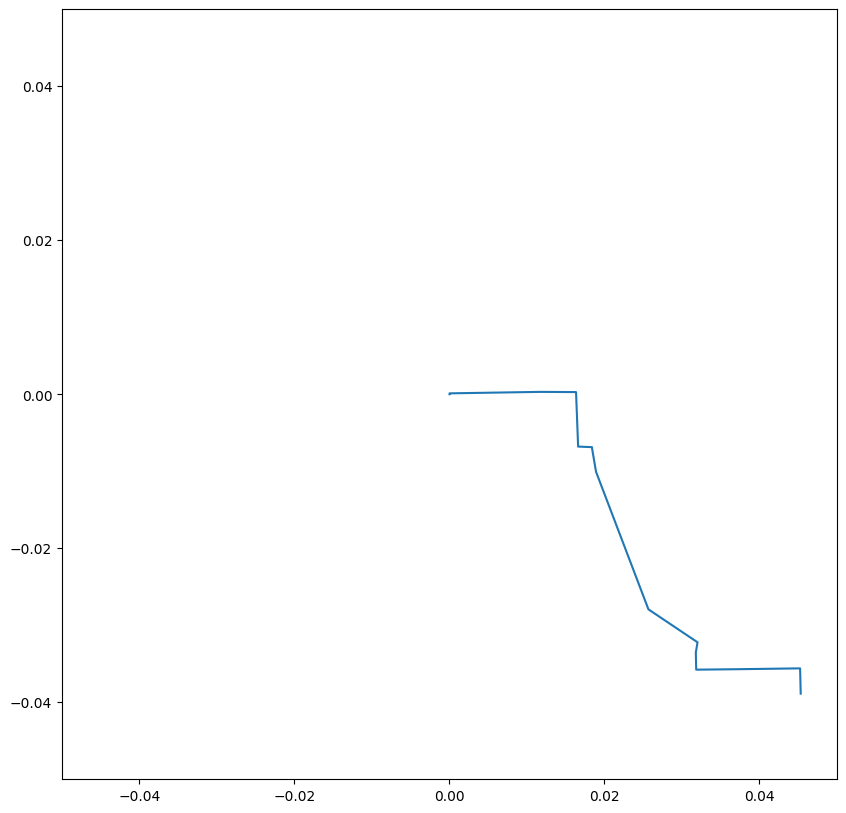

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(taxi_columns[75, -2].trip.path.londiff, taxi_columns[75, -2].trip.path.latdiff);

ax.set_xlim(-0.05, 0.05);
ax.set_ylim(-0.05, 0.05);

Note that this path starts at `(0, 0)`. All of the paths do because these are `londiff` (longitude differences) and `latdiff` (latitude differences).

`taxi[1]` went on a lot of trips.

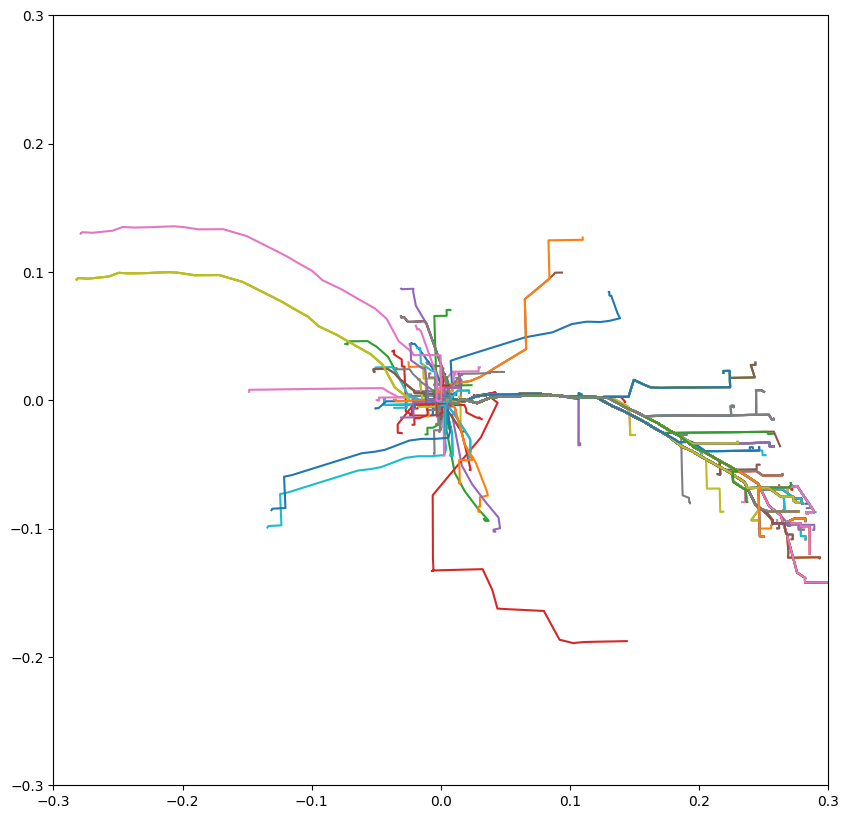

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for x in taxi_columns[1]:
    ax.plot(x.trip.path.londiff, x.trip.path.latdiff);

ax.set_xlim(-0.3, 0.3);
ax.set_ylim(-0.3, 0.3);

Notice that some of these appear to take the same roads, but they're offset in starting point.

We can fix this by adding the `begin.lon` and `begin.lat` to each of these paths.

Each trip has one `begin.lon`, `begin.lat` but a sequence of points along the `path`, so adding the `begin` position involves broadcasting:

In [14]:
begin_position = 10
diffs = ak.Array([0.1, 0.2, 0.3, 0.4, 0.5])

begin_position + diffs

<Array [10.1, 10.2, 10.3, 10.4, 10.5] type='5 * float64'>

Here's what that looks like for a single trip:

In [15]:
begin_position = taxi_columns[75, -2].trip.begin.lon
begin_position

np.float64(-87.66351755)

In [16]:

diffs = taxi_columns[75, -2].trip.path.londiff
diffs

<Array [7.55e-06, 7.55e-06, 0.0117, ..., 0.0452, 0.0453] type='16 * float32'>

In [17]:
broadcasted = begin_position + diffs
broadcasted

<Array [-87.7, -87.7, -87.7, ..., -87.6, -87.6, -87.6] type='16 * float64'>

And here's what that looks like for a lot of trips:

In [18]:
many_begin_positions = taxi_columns[1].trip.begin.lon
many_begin_positions

<Array [-87.7, -87.7, -87.7, ..., -87.6, -87.9, -87.9] type='499 * ?float64'>

In [19]:
many_diffs = taxi_columns[1].trip.path.londiff
many_diffs

<Array [[-2.41e-05, -2.41e-05], [...], ..., []] type='499 * option[var * fl...'>

In [20]:
broadcasted = many_begin_positions + many_diffs
broadcasted

<Array [[-87.7, -87.7], [-87.7, ...], ..., []] type='499 * option[var * flo...'>

Take a close look at the types: `many_begin_positions` is 499 floating point numbers and `many_diffs` is 499 lists of floating point numbers.

The broadcasted sum is 499 lists of floating point numbers, with `option` type to allow for missing values (`None`).

The missing values can be identified and removed with [ak.is_none](https://awkward-array.org/doc/main/reference/generated/ak.is_none.html).

In [21]:
longitudes = taxi_columns[1].trip.begin.lon + taxi_columns[1].trip.path.londiff
latitudes = taxi_columns[1].trip.begin.lat + taxi_columns[1].trip.path.latdiff

longitudes = longitudes[~ak.is_none(longitudes)]
latitudes = latitudes[~ak.is_none(latitudes)]

In [22]:
longitudes

<Array [[-87.7, -87.7], [-87.7, ...], ..., []] type='489 * option[var * flo...'>

Now the trips to the airport and along the lake front are beginning to line up.

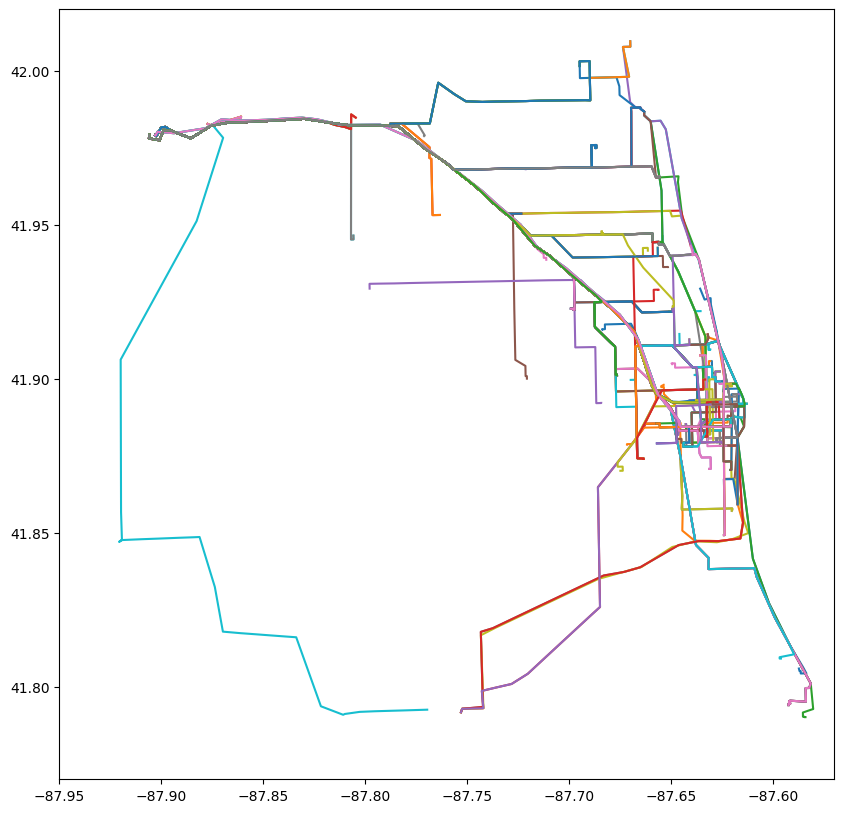

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for x, y in zip(longitudes, latitudes):
    ax.plot(x, y);

ax.set_xlim(-87.95, -87.57);
ax.set_ylim(41.77, 42.02);

Broadcasting `begin.lon`, `begin.lat` offsets into lists of lists, we use the same syntax as for lists.

Just replace `taxi_columns[1]` → `taxi_columns` to apply it to all taxis at once.

In [24]:
all_longitudes = taxi_columns.trip.begin.lon + taxi_columns.trip.path.londiff
all_latitudes = taxi_columns.trip.begin.lat + taxi_columns.trip.path.latdiff

all_longitudes

<Array [[[-87.7, -87.7], ..., [...]], ...] type='353 * var * option[var * f...'>

Since we're not plotting, we'll leave the missing values in for now.

<br><br><br>

### Longitude, latitude → kilometers

Longitudes and latitudes are not uniform distances. One degree of longitude covers 1/360 of the Earth at the equator, but zero length at the north and south poles!

To do meaningful distance calculations, we need to convert them into distance units, such as kilometers.

At Chicago's latitude, one degree of longitude is about 83 km and one degree of longitude is about 111 km.

Let's apply this correction to all path points, across all lists of lists, using broadcasting.

In [25]:
LONGITUDE, LATITUDE = -87.66178320769112, 41.896777262111726   # mean position (center of town)
LON_TO_KM, LAT_TO_KM = 82.98452409203695, 111.07127961503745   # lon, lat → km conversion factors

In [26]:
km_east, km_north = (
    (all_longitudes - LONGITUDE) * LON_TO_KM,
    (all_latitudes - LATITUDE) * LAT_TO_KM,
)

km_east

<Array [[[-4.63, -4.63], ..., [...]], ...] type='353 * var * option[var * f...'>

In real distance units, `taxi[1]`'s trips look like this:

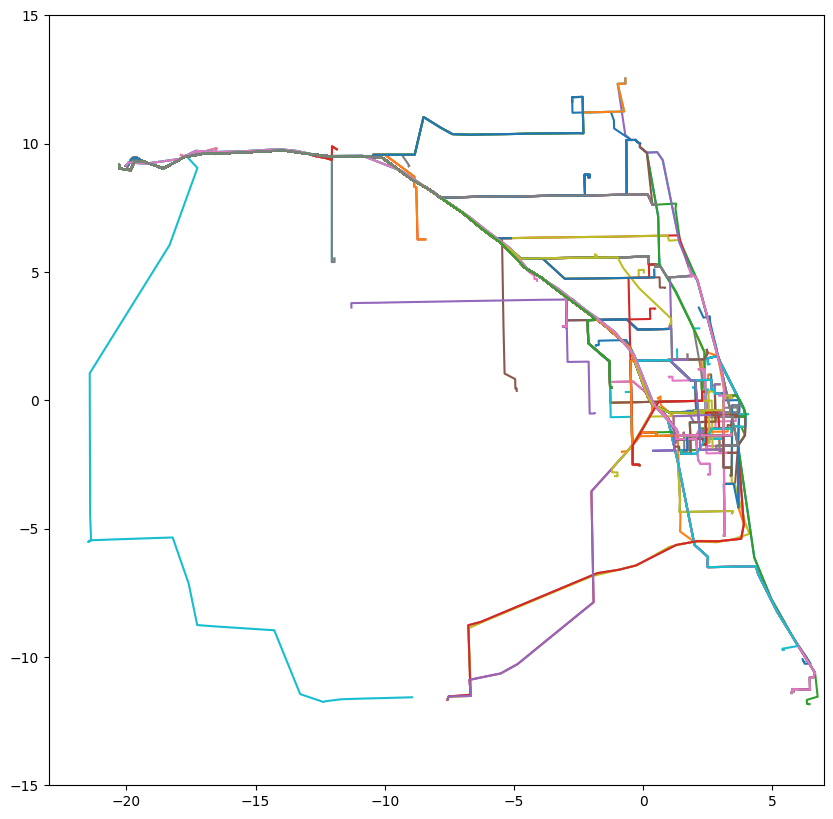

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for x, y in zip(km_east[1], km_north[1]):
    if x is not None and y is not None:
        ax.plot(x, y);

ax.set_xlim(-23, -23 + 30);
ax.set_ylim(-15, -15 + 30);

<br><br><br>

## Exercise 1

The goal of this exercise is to calculate the length of each `path`.

The length of a given `path` is the sum of segment lengths, $\displaystyle \sum_i^{n - 1} \Delta r_i$, where

   * the segment length $\Delta r_i = \sqrt{\Delta x_i^2 + \Delta y_i^2}$
   * $\Delta x_i = x_{i + 1} - x_i$, and $x_i$ is a `km_east` point in the `path`
   * $\Delta y_i = y_{i + 1} - y_i$, and $y_i$ is a `km_north` point in the `path`
   * $n$ is the (variable) number of points in the `path`

<br>

<center>
<img src="../img/length-by-segment.svg" width="500px">
</center>

Here's an example of the calculation for one taxi ride, using an imperative `for` loop:

In [30]:
example_east, example_north = (
    km_east[75, -2],
    km_north[75, -2],
)

length = 0
for i in range(len(example_east) - 1):
    Δx = example_east[i + 1] - example_east[i]
    Δy = example_north[i + 1] - example_north[i]
    Δr = np.sqrt(Δx**2 + Δy**2)
    length += Δr

length

np.float64(7.30448400458981)


**Your solution must** (a) apply to all trips of all taxis in the dataset, so output type is `353 * var * ?float64`, and (b) use array-at-a-time syntax.

It would probably fit on one line.

```python
distances = ???
```

In Jupyter, `distances` should look like this:

```
[[0, 9.63, 6.2, 2.07, 10.1, 0, 1.21, ..., 1.34, 12.2, 6.27, 2.58, 7.27, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 3.56, None, ..., 0, 24.5, 0, 6.22, 2.26, 7.24, 22.1, 0],
 [1.75, 4.82, 3.71, 2.86, 6.41, 6.89, ..., 2.72, 3.65, 28.3, 0, 24.8, None],
 [1.17, 2.39, 1.07, 4.85, 2.95, 2.78, ..., 0.899, 2.61, 2.22, 1.43, 11.9, 3.65],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 22.9, 23.4, 0, 0, 20.5, 22.9, 23.2, 3.09],
 [29, 2.25, 2.91, 0, 27.9, 16.7, 21.1, ..., 2.49, 0, 14.5, 0, 0, 23.6, 3.44],
 [27.5, 1.59, 1.36, 1.48, 2.46, 1.24, ..., 4.43, 6.22, 26.9, None, 0, 1.24],
 [],
 [4.67, 6.23, 1.35, 4.36, 0, 20.9, 0, ..., 26.9, 23.1, None, 20, 0, 16.6, 21.4],
 [0, 0, 0, 0, 0, 0, 0, 2.88, ..., 14.9, 19.9, 17.8, 9.15, 10.6, 12.2, 16.5, 14],
 ...,
 [1.52, 1.93, 5.76, 5.76, 2.95, 0, ..., 4.18, 1.45, 26.9, 3.55, 4.69, 2.92],
 [None, None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, None],
 [None, None, None, None, None, None, ..., None, None, None, None, None, None],
 [0, 9.56, 0, 0, 0, 0, 0, 30.2, 1.41, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [None, 0, 0, 0, 4.89, 0, 0, None, ..., 4.11, 1.6, 0, 9.89, 21.1, 0, None],
 [1.42, 27.6, 1.62, 3.36, 1.62, 1.62, ..., 1.41, 1.62, 2.22, 1.62, 5.11, 7.12],
 [0, 0, 13.9, 27.8, 3.36, 1.41, 2.26, ..., 5.12, 2.94, 5.53, 0, 1.28, 4.67, 0]]
 ------------------------------------------------------------------------------
 353 * var * ?float64
```

<br><br><br>

### Hints (only use if you're stuck)

<details>
    <summary>Differences between neighboring elements in an array?</summary>

<br>

Suppose you have some fenceposts and you want the differences between the fenceposts.

```python
fenceposts = np.array([1.1, 2.2, 3.3, 4.4, 5.5, 10, 20, 30])
```

<br>

Note that `fenceposts[1:]` is `array([ 2.2,  3.3,  4.4,  5.5, 10. , 20. , 30. ])` and `fenceposts[:-1]` is `array([ 1.1,  2.2,  3.3,  4.4,  5.5, 10. , 20. ])`. Just subtract them!

```python
fenceposts[1:] - fenceposts[:-1] → array([ 1.1,  1.1,  1.1,  1.1,  4.5, 10. , 10. ])
```

</details>


<details>
    <summary>Differences between neighboring elements in deeply nested lists of lists?</summary>

<br>

Suppose you have lists of fenceposts and you want the differences between the fenceposts within each list.

```python
fenceposts = ak.Array([[1.1, 2.2, 3.3, 4.4, 5.5], [], [10, 20, 30]])
```

<br>

Note that `fenceposts[:, 1:]` is `<Array [[2.2, 3.3, 4.4, 5.5], [], [20, 30]] type='3 * var * float64'>` and `fenceposts[:, :-1]` is `<Array [[1.1, 2.2, 3.3, 4.4], [], [10, 20]] type='3 * var * float64'>`. Be sure to get the right number of colons (`:`) to pass over the levels of nesting that you don't want to disturb, or use ellipsis (`...`) to descend to the deepest level.

```python
fenceposts[:, 1:] - fenceposts[:, :-1] → <Array [[1.1, 1.1, 1.1, 1.1], [], [10, 10]] type='3 * var * float64'>
```

</details>

<details>
    <summary>Mathematical operations on all elements of an array of lists of lists?</summary>

<br>

When a [NumPy ufunc](https://numpy.org/doc/stable/reference/ufuncs.html) is applied to an Awkward Array, the output is an Awkward Array with the same structure and that ufunc applied to each element.

<br>

Some ufuncs are in the NumPy namespace, such as [np.sqrt](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html), and some are binary operators, such as `-` and `**`.

</details>

<details>
    <summary>Summing over the deepest levels of lists without affecting outer ones?</summary>

<br>

Remember that [ak.sum](https://awkward-array.org/doc/main/reference/generated/ak.sum.html) takes an `axis` argument. It works like NumPy's `axis`, assuming that all irregular-length lists are left-aligned and missing values are skipped over.

<img src="../img/example-reducer-ragged.svg" width="50%">

The innermost lists correspond to the largest allowed `axis` value. As usual in Python, you can start counting from the other end; an alias for the largest allowed `axis` is `axis=-1`.

</details>

<br><br><br>

## Exercise 2

If the main exercise was easy and you need something else to do, try calculating the distance between each beginning (`path[0]`) and each endpoint (`path[-1]`) "as the crow flies."

<center>
<img src="../img/as-the-crow-flies.svg" width="500px">
</center>

(Don't use the `begin.lon`, `begin.lat` and `end.lon`, `end.lat`; use the `path[0]` and `path[-1]`.)

You will encounter an issue when you try to select the first and last item from empty lists—it's an `IndexError`!

In [31]:
contains_empty_lists = ak.Array([[1.1, 2.2, 3.3], [], [4.4, 5.5]])

contains_empty_lists[:, 0]  # should raise an error

IndexError: cannot slice ListArray (of length 3) with array(0): index out of range while attempting to get index 0 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-46/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_next_at.cpp#L21)

<br><br><br>

### First way to fix it: padding the lists

One way to solve this is with [ak.pad_none](https://awkward-array.org/doc/main/reference/generated/ak.pad_none.html) and [ak.fill_none](https://awkward-array.org/doc/main/reference/generated/ak.fill_none.html):

In [32]:
contains_empty_lists

<Array [[1.1, 2.2, 3.3], [], [4.4, 5.5]] type='3 * var * float64'>

In [33]:
ak.pad_none(contains_empty_lists, 2)

<Array [[1.1, 2.2, 3.3], [...], [4.4, 5.5]] type='3 * var * ?float64'>

In [34]:
ak.fill_none(ak.pad_none(contains_empty_lists, 2), 0)

<Array [[1.1, 2.2, 3.3], [0, 0], [4.4, 5.5]] type='3 * var * float64'>

Now you can select element `0` and element `-1`: they're zero!

In [36]:
doesnt_contain_empty_lists = ak.fill_none(ak.pad_none(contains_empty_lists, 2), 0)

doesnt_contain_empty_lists[:, 0]

<Array [1.1, 0, 4.4] type='3 * float64'>

How would you apply this technique to _deeply_ nested lists?

<br><br><br>

### 

Second way to fix it: turning empty lists into None

The [ak.num](https://awkward-array.org/doc/main/reference/generated/ak.num.html) function tells you how many items are in each list. (Note that it takes an `axis` argument; useful if you need to know the lengths of deeply nested lists.)

In [37]:
ak.num(contains_empty_lists)

<Array [3, 0, 2] type='3 * int64'>

You could use this to remove the empty lists from your dataset.

In [38]:


contains_empty_lists[ak.num(contains_empty_lists) != 0]

<Array [[1.1, 2.2, 3.3], [4.4, 5.5]] type='2 * var * float64'>








But that changes the indexing: the sliced array has length `2` instead of length `3`, which would be a problem if you want to align this result with something else derived from the original array.

Awkward Array also has a "mask-slice," which is like slicing with a boolean array except that elements are replaced with `None`, rather than removed.

In [39]:



doesnt_contain_empty_lists = contains_empty_lists.mask[ak.num(contains_empty_lists) != 0]
doesnt_contain_empty_lists

<Array [[1.1, 2.2, 3.3], None, [4.4, 5.5]] type='3 * option[var * float64]'>


The `doesnt_contain_empty_lists` array has length `3`, and you can select item `0` from each list:

In [40]:






doesnt_contain_empty_lists[:, 0]

<Array [1.1, None, 4.4] type='3 * ?float64'>








because item `0` of `None` is `None`. Any calculation you do on `None` is `None`.

How would you apply this technique to _deeply_ nested lists?